In [1]:
!pip -q install ultralytics opencv-python matplotlib pandas pyyaml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 33.4 MB/s eta 0:00:00


In [2]:
import os

# ✅ CHANGE THIS to the folder where your dataset is stored in Drive
DATASET_DIR = "/content/drive/MyDrive/image grounding dataset"

assert os.path.isdir(DATASET_DIR), f"Dataset folder not found: {DATASET_DIR}"
print("✅ Dataset folder:", DATASET_DIR)


✅ Dataset folder: /content/drive/MyDrive/image grounding dataset


In [3]:
import glob, os

yaml_files = glob.glob(os.path.join(DATASET_DIR, "**", "*.yaml"), recursive=True) + \
             glob.glob(os.path.join(DATASET_DIR, "**", "*.yml"), recursive=True)

print("Found YAML files:", len(yaml_files))
for y in yaml_files[:20]:
    print(" ", y)

assert len(yaml_files) > 0, "No data.yaml/yml found inside DATASET_DIR."

# Prefer data.yaml
data_yaml = None
for y in yaml_files:
    if os.path.basename(y).lower() in ["data.yaml", "data.yml"]:
        data_yaml = y
        break
if data_yaml is None:
    data_yaml = yaml_files[0]

print("\n✅ Selected YAML:", data_yaml)

with open(data_yaml, "r", encoding="utf-8") as f:
    print("\n----- YAML CONTENT -----")
    print(f.read())
    print("----- END -----")


Found YAML files: 1
  /content/drive/MyDrive/image grounding dataset/data.yaml

✅ Selected YAML: /content/drive/MyDrive/image grounding dataset/data.yaml

----- YAML CONTENT -----
train: ../train/images
val: ../val/images
test: ../test/images

nc: 6
names:
  ["person", "fire", "smoke", "small_vehicle", "large_vehicle", "two_wheeler"]

----- END -----


In [4]:
import os, glob

def count_imgs(folder):
    return len(glob.glob(os.path.join(folder, "*.jpg"))) + \
           len(glob.glob(os.path.join(folder, "*.png"))) + \
           len(glob.glob(os.path.join(folder, "*.jpeg"))) + \
           len(glob.glob(os.path.join(folder, "*.bmp")))

# Find all folders that contain many images
img_dirs = []
for d in glob.glob(os.path.join(DATASET_DIR, "**"), recursive=True):
    if os.path.isdir(d):
        n = count_imgs(d)
        if n >= 50:
            img_dirs.append((n, d))

img_dirs.sort(reverse=True)
print("Top image folders:")
for n, d in img_dirs[:15]:
    print(f"{n:6d} images -> {d}")

assert len(img_dirs) > 0, "Could not find any folder with images (>=50)."

# Heuristic: try to identify train/val by folder name
train_dir = None
val_dir = None

for _, d in img_dirs:
    name = d.lower()
    if train_dir is None and any(k in name for k in ["train", "training"]):
        train_dir = d
    if val_dir is None and any(k in name for k in ["val", "valid", "validation"]):
        val_dir = d

# Fallback: use biggest folder as train, second biggest as val
if train_dir is None:
    train_dir = img_dirs[0][1]
if val_dir is None:
    val_dir = img_dirs[1][1] if len(img_dirs) > 1 else img_dirs[0][1]

print("\n✅ Using train images:", train_dir, "| count =", count_imgs(train_dir))
print("✅ Using val images  :", val_dir,   "| count =", count_imgs(val_dir))


Top image folders:
 10450 images -> /content/drive/MyDrive/image grounding dataset/train/images
  1556 images -> /content/drive/MyDrive/image grounding dataset/val/images
   434 images -> /content/drive/MyDrive/image grounding dataset/test/images

✅ Using train images: /content/drive/MyDrive/image grounding dataset/train/images | count = 10450
✅ Using val images  : /content/drive/MyDrive/image grounding dataset/val/images | count = 1556


In [5]:
import yaml, os

with open(data_yaml, "r", encoding="utf-8") as f:
    d = yaml.safe_load(f)

# Ensure 'names' exists (Ultralytics needs it)
# Some datasets store classes in 'names' or 'nc' only.
if "names" not in d:
    # If only nc is given, create generic names
    if "nc" in d and isinstance(d["nc"], int):
        d["names"] = [f"class_{i}" for i in range(d["nc"])]
    else:
        raise ValueError("YAML missing 'names' and 'nc'. Cannot infer classes.")

# Ultralytics supports absolute paths directly for train/val
d["train"] = train_dir
d["val"]   = val_dir

# Optional: remove 'path' to avoid path-join confusion
if "path" in d:
    d.pop("path")

fixed_yaml = "/content/data_fixed.yaml"
with open(fixed_yaml, "w", encoding="utf-8") as f:
    yaml.safe_dump(d, f, sort_keys=False)

print("✅ Fixed YAML written:", fixed_yaml)
print(d)


✅ Fixed YAML written: /content/data_fixed.yaml
{'train': '/content/drive/MyDrive/image grounding dataset/train/images', 'val': '/content/drive/MyDrive/image grounding dataset/val/images', 'test': '../test/images', 'nc': 6, 'names': ['person', 'fire', 'smoke', 'small_vehicle', 'large_vehicle', 'two_wheeler']}


In [6]:
from ultralytics import YOLO

model = YOLO("yolov8n.pt")  # fast; change to yolov8s.pt if you want stronger

results = model.train(
    data=fixed_yaml,
    epochs=5,
    imgsz=640,
    batch=16,
    device=0,
    workers=2,
    project="/content/yolo_runs",
    name="drive_dataset_yolo",
    plots=True
)


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.4.8 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/data_fixed.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, i

Run dir: /content/yolo_runs/drive_dataset_yolo
CSV: /content/yolo_runs/drive_dataset_yolo/results.csv
Columns: ['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss', 'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss', 'lr/pg0', 'lr/pg1', 'lr/pg2']


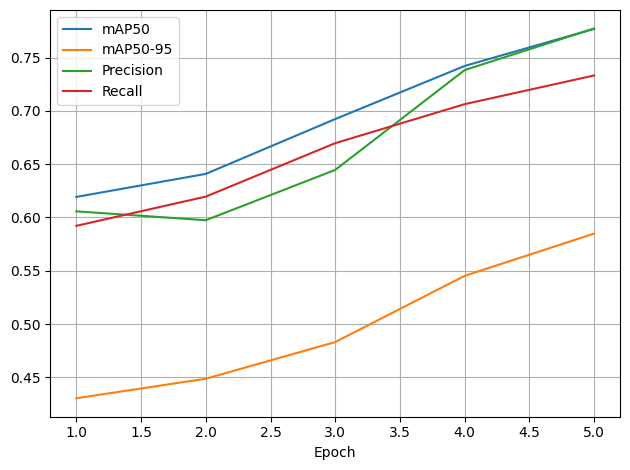

In [7]:
import glob, os
import pandas as pd
import matplotlib.pyplot as plt

run_dir = sorted(glob.glob("/content/yolo_runs/drive_dataset_yolo*"))[-1]
csv_path = os.path.join(run_dir, "results.csv")

print("Run dir:", run_dir)
print("CSV:", csv_path)

df = pd.read_csv(csv_path)
print("Columns:", list(df.columns))

plt.figure()
for col, label in [
    ("metrics/mAP50(B)", "mAP50"),
    ("metrics/mAP50-95(B)", "mAP50-95"),
    ("metrics/precision(B)", "Precision"),
    ("metrics/recall(B)", "Recall"),
]:
    if col in df.columns:
        plt.plot(df["epoch"], df[col], label=label)

plt.xlabel("Epoch")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Val images used: 8

0: 640x640 1 small_vehicle, 5.4ms
1: 640x640 1 small_vehicle, 5.4ms
2: 640x640 2 large_vehicles, 5.4ms
3: 640x640 4 fires, 3 smokes, 5.4ms
4: 640x640 (no detections), 5.4ms
5: 640x640 2 fires, 5.4ms
6: 640x640 1 fire, 5.4ms
7: 640x640 1 fire, 5.4ms
Speed: 1.9ms preprocess, 5.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


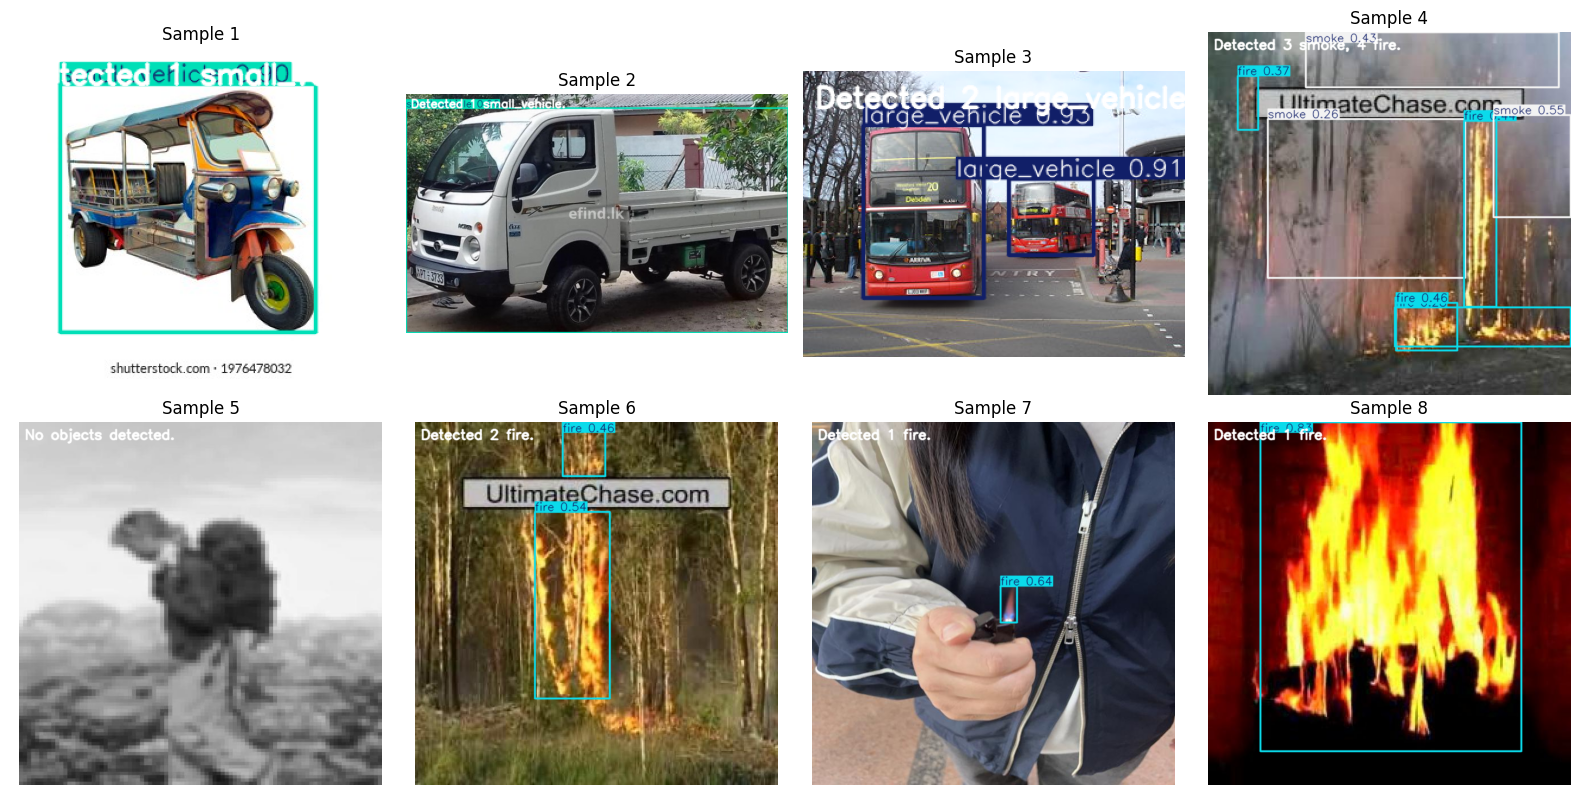

In [8]:
import os, glob
import cv2
import matplotlib.pyplot as plt
from collections import Counter
from ultralytics import YOLO

best_pt = os.path.join(run_dir, "weights", "best.pt")
infer_model = YOLO(best_pt)

# pick some validation images
val_imgs = glob.glob(os.path.join(val_dir, "*.jpg")) + glob.glob(os.path.join(val_dir, "*.png")) + \
           glob.glob(os.path.join(val_dir, "*.jpeg")) + glob.glob(os.path.join(val_dir, "*.bmp"))
val_imgs = val_imgs[:8]

print("Val images used:", len(val_imgs))
assert len(val_imgs) > 0, "No images found in val_dir for inference."

def make_caption(names, cls_ids):
    cnt = Counter([names[int(i)] for i in cls_ids])
    if not cnt:
        return "No objects detected."
    parts = [f"{v} {k}" for k, v in cnt.items()]
    return "Detected " + ", ".join(parts) + "."

preds = infer_model.predict(val_imgs, conf=0.25, iou=0.5)

plt.figure(figsize=(16, 8))
for i, r in enumerate(preds):
    im = r.plot()  # BGR with boxes
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

    cls_ids = r.boxes.cls.cpu().numpy().tolist() if r.boxes is not None else []
    caption = make_caption(infer_model.names, cls_ids)

    cv2.putText(im, caption[:90], (10, 30), cv2.FONT_HERSHEY_SIMPLEX,
                0.8, (255,255,255), 2, cv2.LINE_AA)

    plt.subplot(2, 4, i+1)
    plt.imshow(im)
    plt.axis("off")
    plt.title(f"Sample {i+1}")

plt.tight_layout()
plt.show()
